# Gerardo de Miguel González

# Caret Feature Selection Proof of Concept

## References

**::GMG::** I've followed these references:

  - [Machine Learning Process](https://machinelearningmastery.com/an-introduction-to-feature-selection/) An Introduction to Feature Selection. By Jason Brownlee on October 6, 2014.
  - [R Machine Learning](https://machinelearningmastery.com/feature-selection-with-the-caret-r-package/) Feature Selection with the Caret R Package. By Jason Brownlee on September 22, 2014

## Libraries

In [1]:
#::GMG::Helper function to install missing libraries before loading them
# https://stackoverflow.com/questions/4090169/elegant-way-to-check-for-missing-packages-and-install-them
using<-function(...) {
    libs<-unlist(list(...))
    req<-unlist(lapply(libs,require,character.only=TRUE))
    need<-libs[req==FALSE]
    if(length(need)>0){ 
        install.packages(need)
        lapply(need,require,character.only=TRUE)
    }
}

In [2]:
#::GMG::NOw, the libraries
#::NOTE::Jason uses caret for score and rank features
using('mlbench', 'caTools', 'corrplot', 'PRROC', 'caret')

Loading required package: mlbench
Loading required package: caTools
Loading required package: corrplot
corrplot 0.84 loaded
Loading required package: PRROC
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


**::GMG::** First run caret installation

```R
Loading required package: mlbench
Loading required package: caTools
Loading required package: corrplot
corrplot 0.84 loaded
Loading required package: PRROC
Loading required package: caret
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘generics’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’
Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2

    TRUE

```

In [3]:
#::GMG::Confusion Matrix AND metrics
# cm <- table(Predicted = pima_pred, Actual = pima_test$Outcome)
# https://www.rdocumentation.org/packages/base/versions/3.6.1/topics/table
# https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
# https://stackoverflow.com/questions/33621592/sum-of-antidiagonal-of-a-matrix
# https://stackoverflow.com/questions/14577412/how-to-convert-variable-object-name-into-string
confusion_matrix <- function (true, pred, beta = 1) {
    t <- table(true, pred)
    p <- t[2,2]/sum(t[,2])
    r <- t[2,2]/sum(t[2,])
    s <- t[1,1]/sum(t[1,])
    list(cm = t,
         accuracy = sum(diag(t))/sum(t), 
         #error_rate = sum(diag(t[nrow(t):1,]))/sum(t),
         precision = p, 
         recall = r, #::NOTE::it's also called sensitivity
         f_beta = (1 + beta^2) * p * r/((beta^2 * p) + r),
         specificity = s,
         prevalence = sum(t[2,])/sum(t),
         balanced_accuracy = (r + s) / 2
        )
}

## Dataset

### load

In [4]:
#::GMG::With mlbench there's an aalternative to get the pima indians diabetes dataset
# https://cran.r-project.org/web/packages/mlbench/mlbench.pdf
data(PimaIndiansDiabetes)

In [5]:
head(PimaIndiansDiabetes)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,pos
1,85,66,29,0,26.6,0.351,31,neg
8,183,64,0,0,23.3,0.672,32,pos
1,89,66,23,94,28.1,0.167,21,neg
0,137,40,35,168,43.1,2.288,33,pos
5,116,74,0,0,25.6,0.201,30,neg


In [6]:
dim(PimaIndiansDiabetes)

[1] 768   9

In [7]:
ls()

[1] "confusion_matrix"    "PimaIndiansDiabetes" "using"

### exploratory data analysis

In [8]:
#::GMG::There are subtle differences between the kaggle and mlbench datasets
#       i.e. PimaIndiansDiabetes (say, v1) has the class as a factor (R compliant)
str(PimaIndiansDiabetes)

'data.frame':	768 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


**::GMG::** This dataset consists of 768 observations of 9 variables: 8 variables which will be used as model predictors (number of times pregnant, plasma glucose concentration, diastolic blood pressure (mm Hg), triceps skin fold thickness (in mm), 2-hr serum insulin measure, body mass index, a diabetes pedigree function, and age) and 1 outcome variable (whether or not the patient has diabetes)

In [9]:
summary(PimaIndiansDiabetes)

    pregnant         glucose         pressure         triceps     
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    insulin           mass          pedigree           age        diabetes 
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00   neg:500  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00   pos:268  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00            
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24            
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00            
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00            

In [10]:
#::GMG::Counting 'Outliers' a.k.a "physical impossibilities" (Zeros)
# https://stackoverflow.com/questions/22286957/count-the-number-of-non-zero-elements-of-each-column
apply(X = PimaIndiansDiabetes[c("glucose", "pressure", "triceps", "insulin", "mass")], 
      MARGIN = 2, 
      FUN = function(c) sum(c == 0))

glucose pressure  triceps  insulin     mass 
       5       35      227      374       11

In [11]:
#::GMG::What do I do with the outliers?
#       Glucose, Insulin, BloodPressure, SkinThickness, and BMI 
#       Options: remove, impute, leave them untouched (lto)
#       Chosen: remove (Glucose, BloodPressure, BMI) + lto (SkinThickness, Insulin)
# https://stackoverflow.com/questions/9977686/how-to-remove-rows-with-a-zero-value-in-r
#::NOTE::I cannot remove the outliers from SkinThickness and Insuline 
#        because they're a big slice of the dataset (!)
row_sub <- apply(
             X = PimaIndiansDiabetes[c("glucose", "pressure", "mass")], 
             MARGIN = 1, 
             FUN = function(row) all(row != 0)
)

In [12]:
#::GMG::I remove some of the outliers
pima_mod <- PimaIndiansDiabetes[row_sub,]

In [13]:
#::GMG::Remaining 'Outliers'
apply(X = pima_mod[c("glucose", "pressure", "triceps", "insulin", "mass")], 
      MARGIN = 2, 
      FUN = function(c) sum(c == 0))

glucose pressure  triceps  insulin     mass 
       0        0      192      332        0

In [14]:
#::GMG::The somewhat cleaned dataset ...
str(pima_mod)

'data.frame':	724 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 2 4 10 ...
 $ glucose : num  148 85 183 89 137 116 78 197 110 168 ...
 $ pressure: num  72 66 64 66 40 74 50 70 92 74 ...
 $ triceps : num  35 29 0 23 35 0 32 45 0 0 ...
 $ insulin : num  0 0 0 94 168 0 88 543 0 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 53 30 34 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 2 1 2 ...


In [15]:
#::GMG::Note that 'diabetes' must be numeric to plot the correlation (!)
#       Otherwise it yields Error in cor(pima_mod): 'x' must be numeric
pima_mod$class <- as.numeric(pima_mod$diabetes == 'pos')

In [16]:
#::GMG::Added class column binary 0/1 (neg/pos) nmeric vector from 2 factor diabetes
str(pima_mod)

'data.frame':	724 obs. of  10 variables:
 $ pregnant: num  6 1 8 1 0 5 3 2 4 10 ...
 $ glucose : num  148 85 183 89 137 116 78 197 110 168 ...
 $ pressure: num  72 66 64 66 40 74 50 70 92 74 ...
 $ triceps : num  35 29 0 23 35 0 32 45 0 0 ...
 $ insulin : num  0 0 0 94 168 0 88 543 0 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 53 30 34 ...
 $ diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 2 1 2 ...
 $ class   : num  1 0 1 0 1 0 1 1 0 1 ...


In [17]:
#::GMG::There's a clever way of not including the factor in correlation
# https://stackoverflow.com/questions/9805507/deselecting-a-column-by-name
str(pima_mod[,!(colnames(pima_mod) == "diabetes")])

'data.frame':	724 obs. of  9 variables:
 $ pregnant: num  6 1 8 1 0 5 3 2 4 10 ...
 $ glucose : num  148 85 183 89 137 116 78 197 110 168 ...
 $ pressure: num  72 66 64 66 40 74 50 70 92 74 ...
 $ triceps : num  35 29 0 23 35 0 32 45 0 0 ...
 $ insulin : num  0 0 0 94 168 0 88 543 0 0 ...
 $ mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 30.5 37.6 38 ...
 $ pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ age     : num  50 31 32 21 33 30 26 53 30 34 ...
 $ class   : num  1 0 1 0 1 0 1 1 0 1 ...


In [18]:
#::GMG::For Pima Indians Diabetes there are a bunch of features we can plot in a correlation graph with corrplot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
# https://stat.ethz.ch/R-manual/R-devel/library/stats/html/cor.html
# https://www.statmethods.net/stats/correlations.html
#::NOTE::Se also https://www.statmethods.net/advgraphs/correlograms.html
M <- cor(pima_mod[,!(colnames(pima_mod) == "diabetes")])

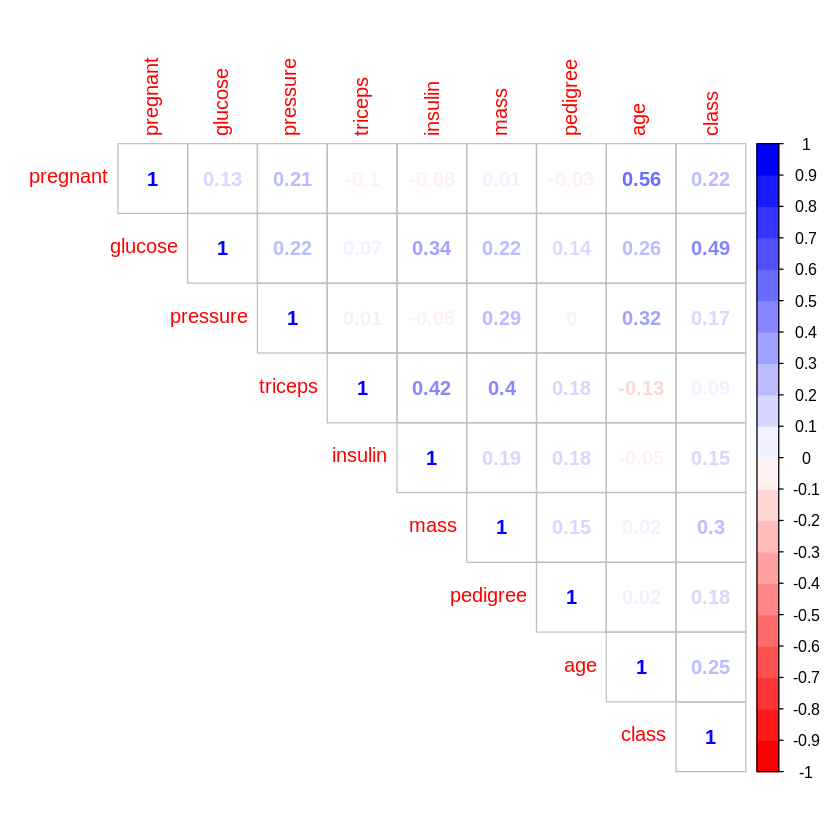

In [19]:
#::GMG::Plpot correlation plot
# http://www.sthda.com/english/wiki/visualize-correlation-matrix-using-correlogram
col<- colorRampPalette(c("red", "white", "blue"))(20)
corrplot(M, method="number", type="upper", col = col)

**::GMG::** There are *weak* correlations between `insuline` and `triceps`, and `triceps` and `mass` and *stronger* between `glucose` and `diabetes` (`class`) and `pregant` and `age`.  I could devise a *cut-off* value to select some of the features based on their correlation (by default *Pearson*) with class as a measure of *relevance*. Or remove some of them based on *their correlation with other features* (some cut-off here as well) as a measure of *redundancy*.

In [20]:
#::GMG::Variables created so far :)
ls()

[1] "col"                 "confusion_matrix"    "M"                  
[4] "pima_mod"            "PimaIndiansDiabetes" "row_sub"            
[7] "using"

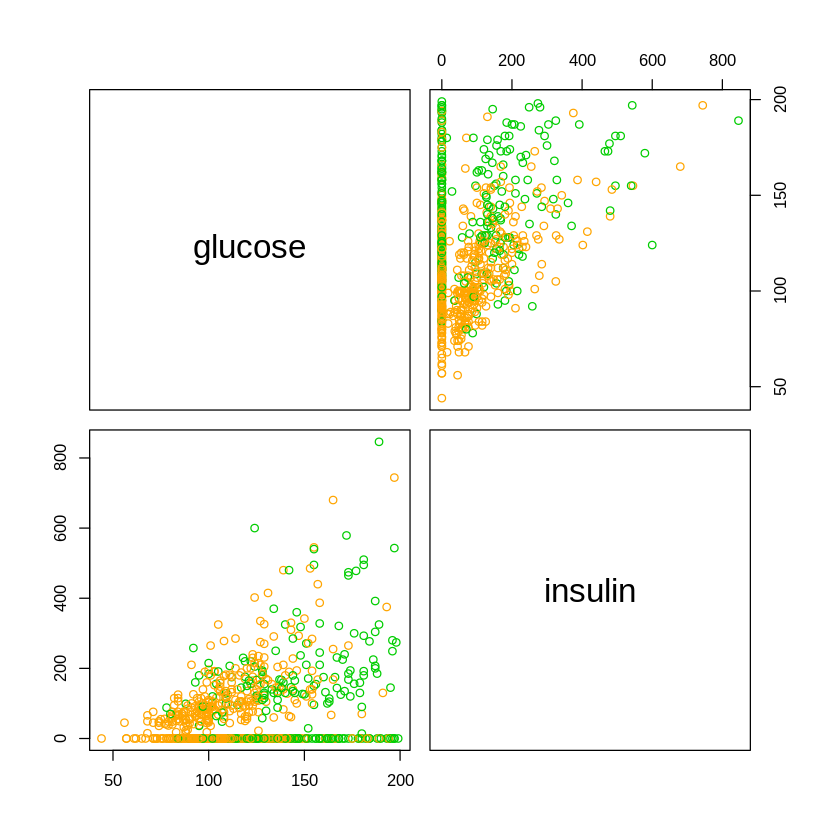

In [21]:
#::GMG::It's useful to look into pairs correlation taking into account the class variable
pairs(glucose ~ insulin, data = pima_mod, col = c("orange", "green3")[unclass(pima_mod$diabetes)])

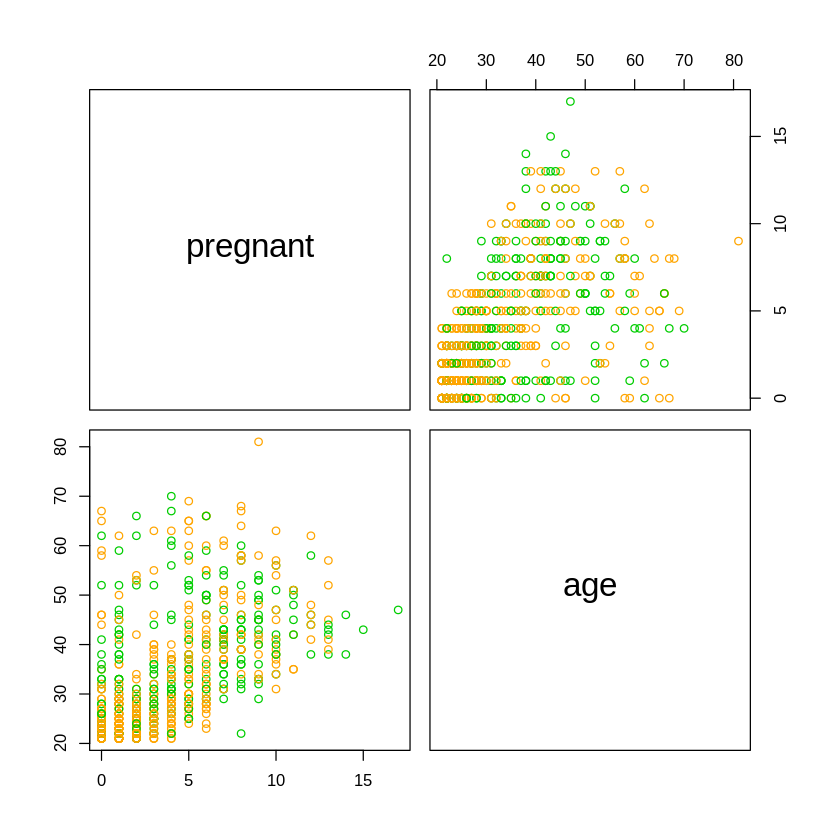

In [22]:
#::GMG::It's useful to look into pairs correlation taking into account the class variable
pairs(pregnant ~ age, data = pima_mod, col = c("orange", "green3")[unclass(pima_mod$diabetes)])

In [23]:
#::GMG::Now I test the imbalance of the dataset
# http://metadatascience.com/2013/07/03/plotting-the-frequency-distribution-using-r/
table(pima_mod$diabetes)


neg pos 
475 249 

In [24]:
prop.table(table(pima_mod$diabetes))


      neg       pos 
0.6560773 0.3439227 

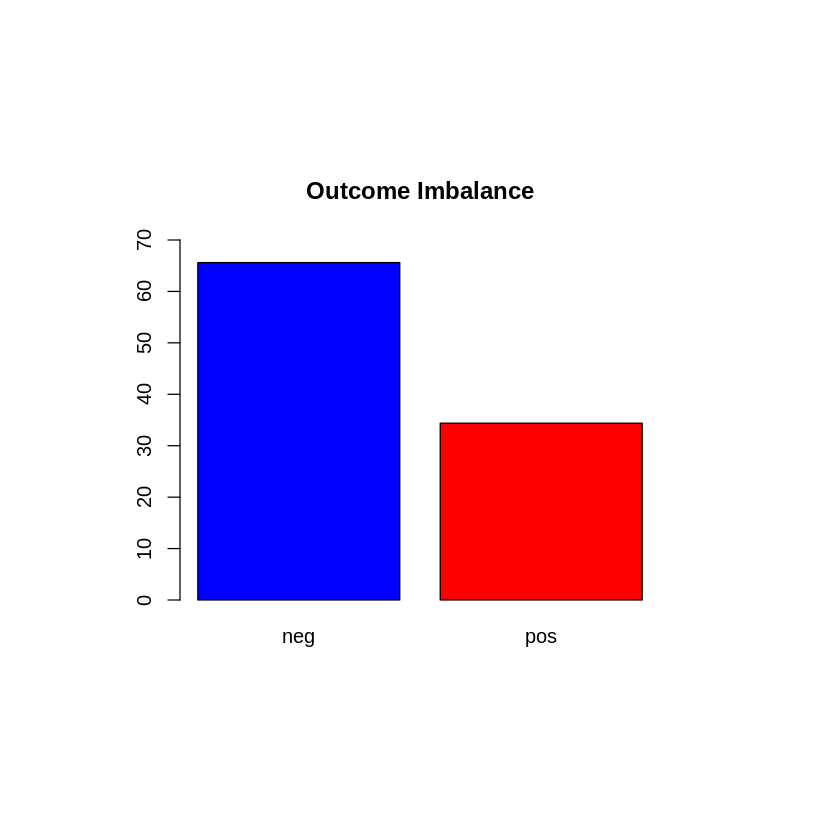

In [25]:
#::GMG::Plot the imbalance
# https://www.statmethods.net/advgraphs/parameters.html
# http://www.programmingr.com/content/positioning-charts-fig-and-fin/
#::NOTE::I don't know how to make the fig smaller and the margins tight (!?)
par(pin = c(4,3))
barplot(100*prop.table(table(pima_mod$diabetes)), 
        col = c('blue', 'red'),
        ylim = c(0,70),
        main = 'Outcome Imbalance')

## Filter: Correlation

### remove redundant features

In [26]:
#::GMG::Here there are the variables/functions in memory (for reference)
ls()

[1] "col"                 "confusion_matrix"    "M"                  
[4] "pima_mod"            "PimaIndiansDiabetes" "row_sub"            
[7] "using"

In [27]:
#::GMG::I don't know why Jason set a seed when scouting for correlation/redudant features
#set.seed(1)

In [82]:
#::GMG::calculate correlation matrix
# corelationMatrix <- cor(PimaIndiansDiabetes[,1:8])
#::NOTE::I've already done this with M (including class)
#::GMG::summarize the correlation matrix
#print(correlationMatrix)
print(M)

            pregnant    glucose      pressure     triceps     insulin
pregnant  1.00000000 0.13491495  2.096681e-01 -0.09568322 -0.08005904
glucose   0.13491495 1.00000000  2.233312e-01  0.07438123  0.33789642
pressure  0.20966808 0.22333124  1.000000e+00  0.01177704 -0.04685568
triceps  -0.09568322 0.07438123  1.177704e-02  1.00000000  0.42087418
insulin  -0.08005904 0.33789642 -4.685568e-02  0.42087418  1.00000000
mass      0.01234162 0.22327644  2.874035e-01  0.40152846  0.19183054
pedigree -0.02599607 0.13662967 -7.527687e-05  0.17625329  0.18265569
age       0.55706615 0.26356023  3.248975e-01 -0.12890811 -0.04941154
class     0.22441717 0.48838421  1.667034e-01  0.09203011  0.14548807
               mass      pedigree         age      class
pregnant 0.01234162 -2.599607e-02  0.55706615 0.22441717
glucose  0.22327644  1.366297e-01  0.26356023 0.48838421
pressure 0.28740346 -7.527687e-05  0.32489747 0.16670342
triceps  0.40152846  1.762533e-01 -0.12890811 0.09203011
insulin  0.1918

In [28]:
class(M)

[1] "matrix"

In [29]:
str(M)

 num [1:9, 1:9] 1 0.1349 0.2097 -0.0957 -0.0801 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:9] "pregnant" "glucose" "pressure" "triceps" ...
  ..$ : chr [1:9] "pregnant" "glucose" "pressure" "triceps" ...


In [30]:
#::GMG::Working with named matrices
# https://monashbioinformaticsplatform.github.io/r-intro/matrices.html
M[,'pregnant']

pregnant     glucose    pressure     triceps     insulin        mass 
 1.00000000  0.13491495  0.20966808 -0.09568322 -0.08005904  0.01234162 
   pedigree         age       class 
-0.02599607  0.55706615  0.22441717

In [31]:
class(M[,'pregnant'])

[1] "numeric"

In [32]:
str(M[,'pregnant'])

 Named num [1:9] 1 0.1349 0.2097 -0.0957 -0.0801 ...
 - attr(*, "names")= chr [1:9] "pregnant" "glucose" "pressure" "triceps" ...


In [38]:
#::GMG::Subsetting with character array
print(M[row.names = c('glucose', 'pressure'), col.names = c('pedigree')])

      glucose      pressure 
 1.366297e-01 -7.527687e-05 


In [40]:
#::GMG::Subsetting
# http://adv-r.had.co.nz/Subsetting.html
M[1:8, 1:8]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
pregnant,1.00000000,0.13491495,2.096681e-01,-0.09568322,-0.08005904,0.01234162,-2.599607e-02,0.55706615
glucose,0.13491495,1.00000000,2.233312e-01,0.07438123,0.33789642,0.22327644,1.366297e-01,0.26356023
pressure,0.20966808,0.22333124,1.000000e+00,0.01177704,-0.04685568,0.28740346,-7.527687e-05,0.32489747
triceps,-0.09568322,0.07438123,1.177704e-02,1.00000000,0.42087418,0.40152846,1.762533e-01,-0.12890811
insulin,-0.08005904,0.33789642,-4.685568e-02,0.42087418,1.00000000,0.19183054,1.826557e-01,-0.04941154
mass,0.01234162,0.22327644,2.874035e-01,0.40152846,0.19183054,1.00000000,1.548582e-01,0.02083534
pedigree,-0.02599607,0.13662967,-7.527687e-05,0.17625329,0.18265569,0.15485819,1.000000e+00,0.02309810
age,0.55706615,0.26356023,3.248975e-01,-0.12890811,-0.04941154,0.02083534,2.309810e-02,1.00000000


In [45]:
M[!(rownames(M) == "class"),!(colnames(M) == "class")]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age
pregnant,1.00000000,0.13491495,2.096681e-01,-0.09568322,-0.08005904,0.01234162,-2.599607e-02,0.55706615
glucose,0.13491495,1.00000000,2.233312e-01,0.07438123,0.33789642,0.22327644,1.366297e-01,0.26356023
pressure,0.20966808,0.22333124,1.000000e+00,0.01177704,-0.04685568,0.28740346,-7.527687e-05,0.32489747
triceps,-0.09568322,0.07438123,1.177704e-02,1.00000000,0.42087418,0.40152846,1.762533e-01,-0.12890811
insulin,-0.08005904,0.33789642,-4.685568e-02,0.42087418,1.00000000,0.19183054,1.826557e-01,-0.04941154
mass,0.01234162,0.22327644,2.874035e-01,0.40152846,0.19183054,1.00000000,1.548582e-01,0.02083534
pedigree,-0.02599607,0.13662967,-7.527687e-05,0.17625329,0.18265569,0.15485819,1.000000e+00,0.02309810
age,0.55706615,0.26356023,3.248975e-01,-0.12890811,-0.04941154,0.02083534,2.309810e-02,1.00000000


In [59]:
#::GMG::Conditional subsetting?
# https://www.r-bloggers.com/which-function-in-r/
which(M > 0.5 & M != 1, arr.ind = T, useNames = T)

,row,col
age,8,1
pregnant,1,8


In [100]:
#::GMG::find attributes that are highly corrected (ideally >0.75)
#::NOTE::Do I need caret for this?
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/findCorrelation
# https://www.kaggle.com/questions-and-answers/42572
# https://rdrr.io/cran/caret/src/R/findCorrelation.R
#::NOTE::Here the description is relevant
#        The absolute values of pair-wise correlations are considered. If two variables have a high correlation, 
#        the function looks at the mean absolute correlation of each variable and removes the variable with the 
#        largest mean absolute correlation.
highlyCorrelated <- caret::findCorrelation(M, cutoff = 0.5, verbose = T, names = T)

Compare row 8  and column  1 with corr  0.557 
  Means:  0.202 vs 0.187 so flagging column 8 
All correlations <= 0.5 


In [101]:
#::GMG::print indexes of highly correlated attributes
#::NOTE::What indices?
print(highlyCorrelated)

[1] "age"


In [95]:
attributes(M[1:8, 1:8])[[2]][[1]][highlyCorrelated]

[1] "age"

**::GMG::** So ai guess`age` is a candidate to elimination here. How do I show this removal to be useful? I mean, how do I show that after removing `age` there's some soft of improvement?

## Embedded: LVQ

### rank features by importance

**::GMG::** Here Jason uses [`lvq`](https://rdrr.io/cran/class/src/R/lvq.R) from package [`class`](https://cran.r-project.org/web/packages/class/index.html)([see documentation](https://cran.r-project.org/web/packages/class/class.pdf)) (which is loaded in the evironment by default) but using `caret` as a *framework* for setting the experiment: train, test and evaluation. This is a pattern I may replicate in my R code in TFM. I have two references of usage:

  - [datatechnotes](https://www.datatechnotes.com/2018/10/learning-vector-quantization.html) Classification with Learning Vector Quantization in R (2018)
  - [Medium](https://medium.com/@akshit.singh2504/using-learning-vector-quantization-for-classification-in-r-6be6588b471f) Using Learning Vector Quantization for Classification in R. By Akshit Singh (2019)

**::NOTE::** `lvq` is a *neural network model* so I guess it should be use when there are *a lot of features* or samples ... (**?**) and therefore I'm in doubt here because this dataset doesn't fit with the profile of an ideal candidate dataset (perhaps a GEO microarray gene expression dataset is better ...)

**::GMG::** Jason has also a reference about `lvq`:

  - [Understanding ML Algorithms](https://machinelearningmastery.com/learning-vector-quantization-for-machine-learning/) Learning Vector Quantization for Machine Learning. By Jason Brownlee on April 18, 2016

In [96]:
#::GMG::Which libraries are there by default?
list.files(R.home('library'))

[1] "base"         "boot"         "class"        "cluster"      "codetools"   
 [6] "compiler"     "datasets"     "foreign"      "graphics"     "grDevices"   
[11] "grid"         "KernSmooth"   "lattice"      "MASS"         "Matrix"      
[16] "methods"      "mgcv"         "nlme"         "nnet"         "parallel"    
[21] "rpart"        "spatial"      "splines"      "stats"        "stats4"      
[26] "survival"     "tcltk"        "tools"        "translations" "utils"

In [97]:
#::GMG::more on listing loaded packages
# https://stat.ethz.ch/R-manual/R-patched/library/base/html/zpackages.html
# https://stackoverflow.com/questions/38481980/get-the-list-of-installed-packages-by-user-in-r
(.packages())

[1] "caret"     "ggplot2"   "lattice"   "PRROC"     "corrplot"  "caTools"  
 [7] "mlbench"   "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[13] "methods"   "base"

In [99]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] caret_6.0-84     ggplot2_3.2.0    lattice_0.20-38  PRROC_1.3.1     
[5] corrplot_0.84    caTools_1.17.1.2 mlbench_2.1-1   

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3       tidyselect_0.2.5   repr_1.0.1         reshape2_1.4.3    
 [5] purrr_0.3.2

In [102]:
#::GMG::Now I'm using caret and I need to set the seed to make the experimet reproducble
set.seed(seed = 2)

In [103]:
#::GMG::prepare training scheme
#::NOTE::Best practice included, i.e using 3 repeated 10-fold CV
control <- caret::trainControl(method="repeatedcv", number=10, repeats=3)

In [105]:
using('e1071')

Loading required package: e1071
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘e1071’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Loading required package: e1071


[[1]]
[1] TRUE

**::GMG::** First run `e1071` wasn't installed

```R
Loading required package: e1071
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘e1071’”Installing package into ‘/home/jovyan/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)
Loading required package: e1071

    TRUE
```

In [106]:
#::GMG::train the model
#::NOTE::I use the original dataset, caret takes care of the train/test CV and whatnot
#        'lvq' is set by name but I guess lvq from CLASS it's used ... I'm in doubt at this point
#        scale pre-processing is flagged, which I know it's common in NN methods because is good for
#        backpropagation ... however, I don`t know if that is the case here.
#::ERROR::Error: package e1071 is required if not loaded :)
# https://cran.r-project.org/web/packages/e1071/e1071.pdf
#::NOTE::I don't think this library is needed here but caret need it in general. However I don't know
#        why it wasn't loaded along with caret!
model <- caret::train(diabetes~., 
               data = PimaIndiansDiabetes, 
               method = "lvq", 
               preProcess = "scale", 
               trControl = control)

In [107]:
#::GMG::estimate variable importance
#::NOTE::There's a lot of to learned here
# https://www.rdocumentation.org/packages/caret/versions/6.0-84/topics/varImp
# https://topepo.github.io/caret/variable-importance.html
# https://stackoverflow.com/questions/37888619/difference-between-varimp-caret-and-importance-randomforest-for-random-fores
# https://stats.stackexchange.com/questions/113618/caret-package-in-r-get-top-variable-of-importance
importance <- caret::varImp(model, scale=FALSE)

In [108]:
str(importance)

List of 3
 $ importance:'data.frame':	8 obs. of  2 variables:
  ..$ neg: num [1:8] 0.62 0.788 0.586 0.554 0.538 ...
  ..$ pos: num [1:8] 0.62 0.788 0.586 0.554 0.538 ...
 $ model     : chr "ROC curve"
 $ calledFrom: chr "varImp"
 - attr(*, "class")= chr "varImp.train"


In [109]:
class(importance)

[1] "varImp.train"

In [110]:
#::GMG::I can print importanca
print(importance)

ROC curve variable importance

         Importance
glucose      0.7881
mass         0.6876
age          0.6869
pregnant     0.6195
pedigree     0.6062
pressure     0.5865
triceps      0.5536
insulin      0.5379


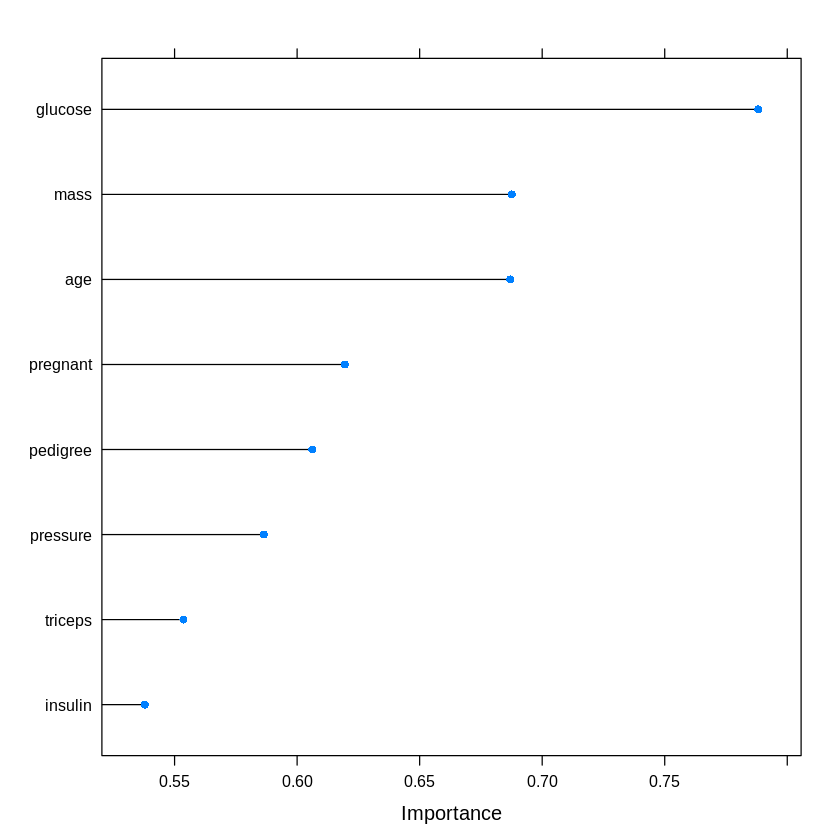

In [111]:
#::GMG:: And plot importance
plot(importance)

## Wrapper: RFE

In [114]:
ls()

[1] "col"                 "confusion_matrix"    "control"            
 [4] "highlyCorrelated"    "importance"          "M"                  
 [7] "model"               "pima_mod"            "PimaIndiansDiabetes"
[10] "row_sub"             "using"

In [115]:
#::GMG::define the control using a random forest selection function
#::NOTE::Then again caret takes care of split 10-fold CV
# https://topepo.github.io/caret/recursive-feature-elimination.html
#::NOTE::Shouldn`t I split train/test to validate at the end?
control_rfe <- caret::rfeControl(
    functions = rfFuncs, 
    method = "cv", 
    number = 10)

In [116]:
#::GMG::run the RFE algorithm
#::NOTE::it takes several seconds to complet. I guess for bigger feature/sample datasets I need power)
results <- rfe(
    PimaIndiansDiabetes[,1:8], 
    PimaIndiansDiabetes[,9], 
    sizes = c(1:8), 
    rfeControl = control_rfe)

In [117]:
str(results)

List of 17
 $ pred        : NULL
 $ variables   :'data.frame':	360 obs. of  6 variables:
  ..$ neg      : num [1:360] 36.23 15.05 14.63 7.78 5.02 ...
  ..$ pos      : num [1:360] 36.23 15.05 14.63 7.78 5.02 ...
  ..$ Overall  : num [1:360] 36.23 15.05 14.63 7.78 5.02 ...
  ..$ var      : chr [1:360] "glucose" "mass" "age" "pregnant" ...
  ..$ Variables: int [1:360] 8 8 8 8 8 8 8 8 7 7 ...
  ..$ Resample : chr [1:360] "Fold01" "Fold01" "Fold01" "Fold01" ...
 $ results     :'data.frame':	8 obs. of  5 variables:
  ..$ Variables : int [1:8] 1 2 3 4 5 6 7 8
  ..$ Accuracy  : num [1:8] 0.693 0.733 0.751 0.755 0.768 ...
  ..$ Kappa     : num [1:8] 0.264 0.391 0.436 0.457 0.475 ...
  ..$ AccuracySD: num [1:8] 0.0255 0.0318 0.0335 0.044 0.0362 ...
  ..$ KappaSD   : num [1:8] 0.0736 0.0795 0.0798 0.0972 0.0888 ...
 $ bestSubset  : int 8
 $ fit         :List of 18
  ..$ call           : language randomForest(x = x, y = y, importance = TRUE)
  ..$ type           : chr "classification"
  ..$ predic

In [118]:
class(results)

[1] "rfe"

In [119]:
#::GMG::summarize the results
#::NOTE::I can choose the metrics in rfe(), see doc
# https://topepo.github.io/caret/recursive-feature-elimination.html
print(results)


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.6927 0.2638    0.02552 0.07363         
         2   0.7330 0.3911    0.03184 0.07951         
         3   0.7513 0.4357    0.03354 0.07980         
         4   0.7552 0.4573    0.04405 0.09718         
         5   0.7681 0.4748    0.03623 0.08880         
         6   0.7617 0.4561    0.05212 0.12254         
         7   0.7603 0.4561    0.04797 0.11120         
         8   0.7760 0.4883    0.03979 0.09720        *

The top 5 variables (out of 8):
   glucose, mass, age, pregnant, pedigree



In [120]:
#::GMG::list the chosen features
#::NOTE::Note that in summary says that 
#        The top 5 variables (out of 8):
#        glucose, mass, age, pregnant, pedigree
predictors(results)

[1] "glucose"  "mass"     "age"      "pregnant" "pedigree" "insulin"  "triceps" 
[8] "pressure"

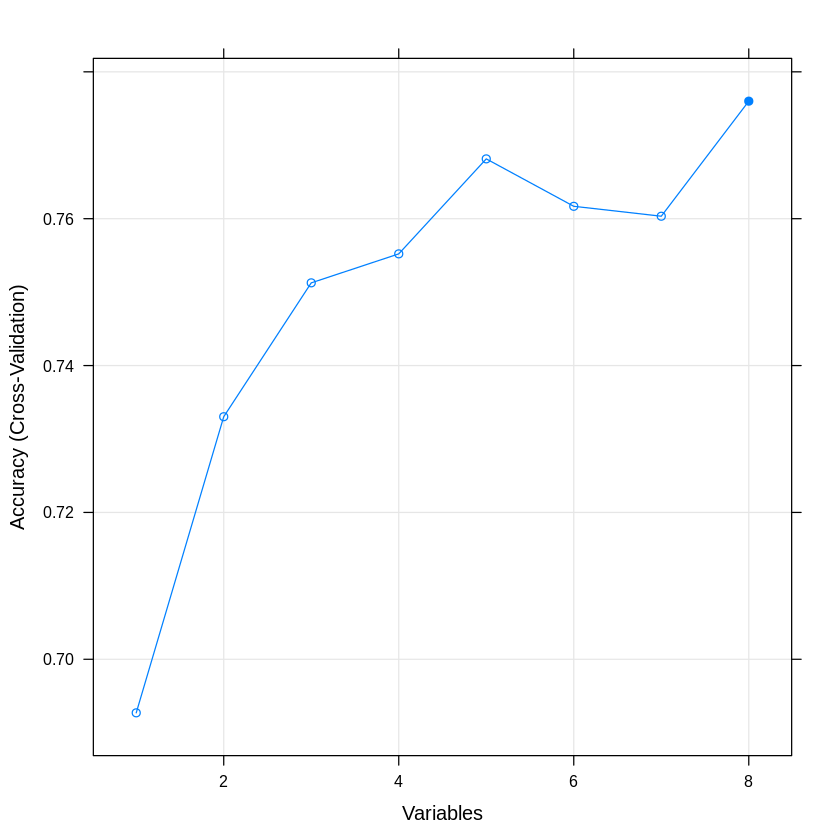

In [121]:
#::GMG::plot the results
plot(results, type=c("g", "o"))

**::GMG::** I think I should have a test set to validate the feature selection out of sample.